# Hyperparameter Tuning for Classifier

For comparison, we will do a simple hyperparameter optimization using other embedding models. Results are similar to the ones using `gte-large`.

## Import Libraries

In [ ]:
%pip install "ray[tune]"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import os
absolute_path = os.getcwd()

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
import seaborn as sns

import tempfile
from pathlib import Path
from datetime import datetime

from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle

## Loading SST-5 Vectors

In [40]:
class SST5Datasets(Dataset):
  def __init__(self, model_name, df_type):
    self.df = pd.read_parquet(absolute_path + f"/SST-5_{df_type}.parquet").rename(
      columns={'truth': 'rating', 'vectors': 'vector'}
    )

    self.X = torch.from_numpy(np.load(absolute_path + f"/embeddings/{model_name}_{df_type}.npy"))
    self.y = torch.tensor((self.df['rating'] - 1).values, dtype=torch.int64)

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    return self.X[idx, :], self.y[idx]

In [6]:
def data_loaders(model_name, batch_size):
  trainset = SST5Datasets(model_name, "train")
  trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True
  )

  valset = SST5Datasets(model_name, "validation")
  valloader = torch.utils.data.DataLoader(
    valset, batch_size=batch_size, shuffle=True
  )

  length = len(trainset[0][0])

  return length, trainloader, valloader

## Neural Network

In [7]:
def create_model(widths = [1024, 64], dropout = [0.0]):
  assert len(widths) == len(dropout) + 1
  layers = []

  for w1, w2, p in zip(widths, widths[1:], dropout):
    layers.append(nn.Dropout(p))
    layers.append(nn.Linear(w1, w2))
    layers.append(nn.ReLU())

  layers.append(nn.Linear(w2, 5))

  return nn.Sequential(*layers)

In [84]:
def train_step(model, optimizer, loss_fn, trainloader, epoch_index, device):
  model.train()

  running_loss = 0.0
  batches = 0
  correct = 0
  total = 0

  for inputs, labels in trainloader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      batch_size = inputs.shape[0]
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total += batch_size
      running_loss += loss.item()

      _, predicted = torch.max(outputs, dim=1)
      correct += (predicted == labels).sum().item()
      batches += 1

  return running_loss / batches, correct / total

In [32]:
def eval_metrics(model, loss_fn, loader, device):
  model.eval()

  running_loss = 0.0
  batches = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      batch_size = inputs.shape[0]
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)

      total += batch_size
      running_loss += loss.item()

      _, predicted = torch.max(outputs, dim=1)
      correct += (predicted == labels).sum().item()
      batches += 1

  return running_loss / batches, correct / total

In [20]:
def train_model(config):
  input_width, trainloader, valloader = data_loaders(
    config["embedding_name"], config["batch_size"]
  )

  device = "cuda:0" if torch.cuda.is_available() else "cpu"

  assert config["input_width"] == input_width

  depth = config["depth"]
  widths = [input_width] + [config[f"l{index}"] for index in range(1, depth + 1)]
  dropouts = [config[f"d{index}"] for index in range(1, depth + 1)]

  model = create_model(widths, dropouts)
  model.to(device)

  optimizer = torch.optim.Adam(
    model.parameters(), lr=config["lr"]
  )
  loss_fn = nn.CrossEntropyLoss()

  checkpoint = get_checkpoint()
  if checkpoint:
    with checkpoint.as_directory() as checkpoint_dir:
      data_path = Path(checkpoint_dir) / "data.pkl"
      with open(data_path, "rb") as fp:
          checkpoint_state = pickle.load(fp)
      start_epoch = checkpoint_state["epoch"]
      model.load_state_dict(checkpoint_state["model_state_dict"])
      optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
  else:
      start_epoch = 0

  for epoch in range(start_epoch, 200):
    train_loss, train_acc = train_step(
      model, optimizer, loss_fn, trainloader, epoch, device
    )

    val_loss, val_acc = eval_metrics(model, loss_fn, valloader, device)

    if epoch % 5 == 4:
      print(f"EPOCH {epoch + 1:2d}", end=" ")
      print(f"LOSS train {train_loss:.4f} val {val_loss:.4f}", end=" ")
      print(f"ACCURACY train {train_acc:.4f} val {val_acc:.4f}")

    checkpoint_data = {
      "epoch": epoch,
      "model_state_dict": model.state_dict(),
      "optimizer_state_dict": optimizer.state_dict(),
    }

    with tempfile.TemporaryDirectory() as checkpoint_dir:
      data_path = Path(checkpoint_dir) / "data.pkl"

      with open(data_path, "wb") as fp:
        pickle.dump(checkpoint_data, fp)

      checkpoint = Checkpoint.from_directory(checkpoint_dir)
      train.report(
        {"loss": val_loss, "accuracy": val_acc},
        checkpoint=checkpoint,
      )

  print("Finished Training")

In [120]:
def tuning(embedding_name, num_samples, max_num_epochs):
  device = "cuda:0" if torch.cuda.is_available() else "cpu"

  input_width, _, _ = data_loaders(embedding_name, 32)

  config = {
    "embedding_name": embedding_name,
    "input_width": input_width,
    "depth": tune.choice([1, 2, 3, 4, 5]),
    "l1": tune.choice([2 ** i for i in range(2, 9)]),
    "l2": tune.choice([2 ** i for i in range(2, 9)]),
    "l3": tune.choice([2 ** i for i in range(2, 9)]),
    "l4": tune.choice([2 ** i for i in range(2, 9)]),
    "l5": tune.choice([2 ** i for i in range(2, 9)]),
    "d1": tune.uniform(0.0, 0.7),
    "d2": tune.uniform(0.0, 0.7),
    "d3": tune.uniform(0.0, 0.7),
    "d4": tune.uniform(0.0, 0.7),
    "d5": tune.uniform(0.0, 0.7),
    "lr": tune.loguniform(1e-5, 1e-2),
    "batch_size": tune.choice([8, 16, 32, 64, 128]),
  }
  scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=max_num_epochs,
    grace_period=1,
    reduction_factor=2,
  )
  result = tune.run(
    train_model,
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
  )

  best_trial = result.get_best_trial("accuracy", "max", "all")
  print(f"Best trial config: {best_trial.config}")
  print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
  print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

  return result

In [55]:
def show_metrics(model, embedding_name, device, data_type = "test"):
  testset = SST5Datasets(embedding_name, data_type)
  testloader = torch.utils.data.DataLoader(
    testset, batch_size=32, shuffle=True
  )

  confusion_matrix = np.zeros((5,5))
  model.eval()

  with torch.no_grad():
    for input, labels in testloader:
      input, labels = input.to(device), labels.to(device)
      outputs = model(input)

      _, predicted = torch.max(outputs, dim=1)

      for label, pred in zip(labels, predicted):
        confusion_matrix[pred, label] += 1

  accuracy = sum(confusion_matrix[i, i] for i in range(5)) / len(testset)
  almost_acc = 1 / len(testset) * (
      sum(confusion_matrix[i, i] for i in range(5)) +
      sum(confusion_matrix[i, i + 1] for i in range(4)) +
      sum(confusion_matrix[i, i - 1] for i in range(1, 5))
  )

  confusion_matrix /= confusion_matrix.sum(axis=1, keepdims=True)

  print()
  print(f"Accuracy on {data_type}:".ljust(40), f"{accuracy:.6f}")
  print(f"Accuracy on {data_type} (up to \u00b11):".ljust(40), f"{almost_acc:.6f}")
  ax = sns.heatmap(
      confusion_matrix, annot=True,
      yticklabels=list(range(1,6)),
      xticklabels=list(range(1,6)),
      cmap="viridis", vmin=0.0, vmax=1.0,
  )
  ax.set(xlabel="Predicted Label", ylabel="True label")

In [66]:
def show_best_metrics(result, embedding_name, data_type, device="cpu"):
  best_trial = result.get_best_trial("accuracy", "max", "all")
  depth = best_trial.config["depth"]
  widths = [best_trial.config["input_width"]]
  widths += [best_trial.config[f"l{index}"] for index in range(1, depth + 1)]
  dropouts = [best_trial.config[f"d{index}"] for index in range(1, depth + 1)]

  best_model = create_model(widths, dropouts)
  best_model.to(device)

  best_checkpoint = result.get_best_checkpoint(
    trial=best_trial, metric="accuracy", mode="max"
  )
  with best_checkpoint.as_directory() as checkpoint_dir:
    data_path = Path(checkpoint_dir) / "data.pkl"
    with open(data_path, "rb") as fp:
      best_checkpoint_data = pickle.load(fp)

    best_model.load_state_dict(best_checkpoint_data["model_state_dict"])
    show_metrics(best_model, embedding_name, device, data_type=data_type)

In [103]:
def save_model(result, embedding_name):
  best_trial = result.get_best_trial("accuracy", "max", "all")
  depth = best_trial.config["depth"]
  widths = [best_trial.config["input_width"]]
  widths += [best_trial.config[f"l{index}"] for index in range(1, depth + 1)]
  dropouts = [best_trial.config[f"d{index}"] for index in range(1, depth + 1)]

  best_model = create_model(widths, dropouts)

  best_checkpoint = result.get_best_checkpoint(
    trial=best_trial, metric="accuracy", mode="max"
  )

  with best_checkpoint.as_directory() as checkpoint_dir:
    data_path = Path(checkpoint_dir) / "data.pkl"
    with open(data_path, "rb") as fp:
      best_checkpoint_data = pickle.load(fp)

    best_model.load_state_dict(best_checkpoint_data["model_state_dict"])

  timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
  epoch = int(best_checkpoint.path[-6:])
  model_path = '/models/raytune/{}_{}_{}'.format(embedding_name, timestamp, epoch)
  torch.save(best_model.state_dict(), absolute_path + model_path)

## Finding Best Classifiers

### stella_en_1.5B_v5

In [41]:
embedding_name = "stella_en_1.5B_v5"
result = tuning(embedding_name, num_samples=500, max_num_epochs=70)

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))



Accuracy on validation:                  0.570391
Accuracy on validation (up to ±1):       0.959128


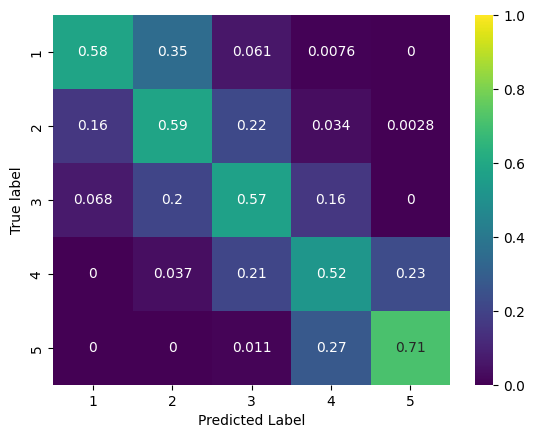

In [67]:
show_best_metrics(result, embedding_name, "validation")

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))



Accuracy on test:                        0.577828
Accuracy on test (up to ±1):             0.964706


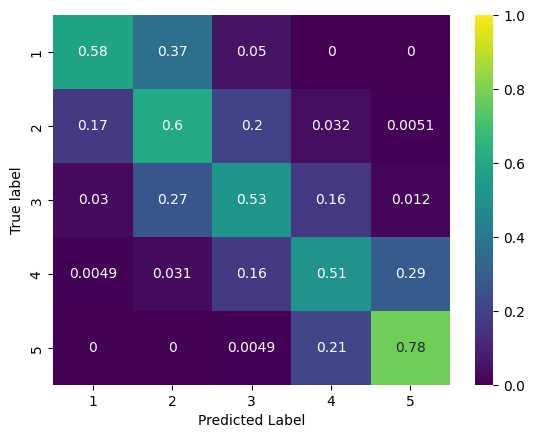

In [68]:
show_best_metrics(result, embedding_name, "test")

In [104]:
save_model(result, embedding_name)

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


### stella_en_400M_v5

In [105]:
embedding_name = "stella_en_400M_v5"
result = tuning(embedding_name, num_samples=500, max_num_epochs=70)

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))



Accuracy on validation:                  0.569482
Accuracy on validation (up to ±1):       0.950954


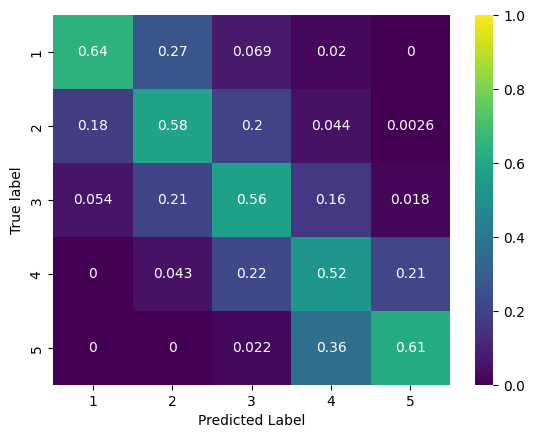

In [107]:
show_best_metrics(result, embedding_name, "validation")

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))



Accuracy on test:                        0.571041
Accuracy on test (up to ±1):             0.964253


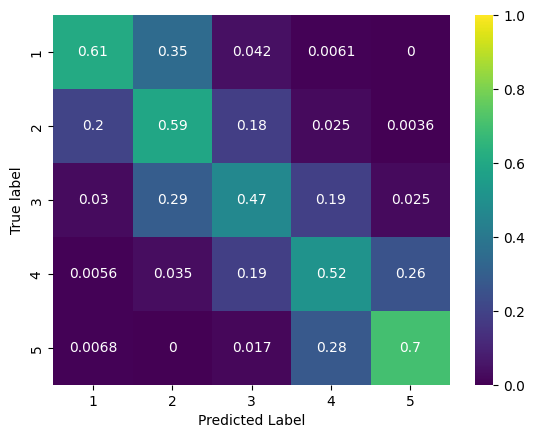

In [108]:
show_best_metrics(result, embedding_name, "test")

In [109]:
save_model(result, embedding_name)

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


### gte-Qwen2-1.5B-instruct

In [112]:
embedding_name = "gte-Qwen2-1.5B-instruct"
result = tuning(embedding_name, num_samples=500, max_num_epochs=70)

Output hidden; open in https://colab.research.google.com to view.


Accuracy on validation:                  0.555858
Accuracy on validation (up to ±1):       0.950045


/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


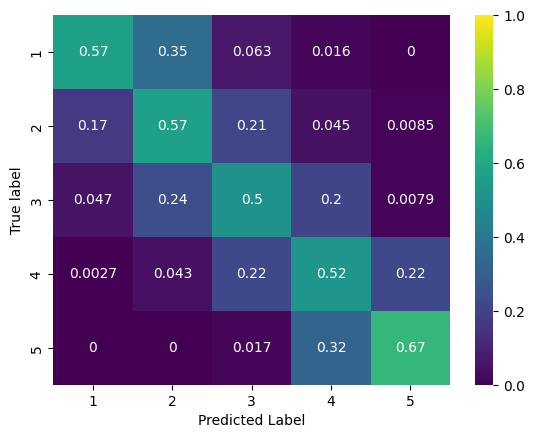

In [113]:
show_best_metrics(result, embedding_name, "validation")

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))



Accuracy on test:                        0.565611
Accuracy on test (up to ±1):             0.961991


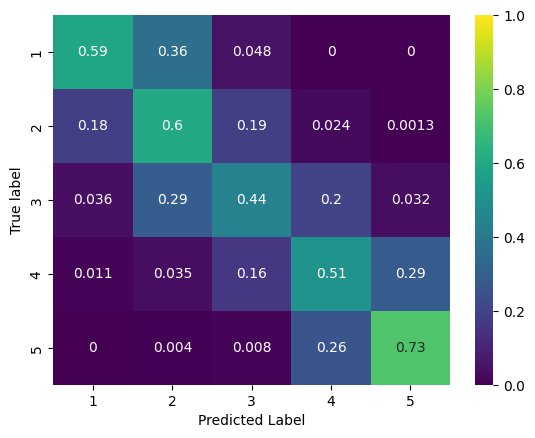

In [114]:
show_best_metrics(result, embedding_name, "test")

In [115]:
save_model(result, embedding_name)

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


### stella_en_1.5B_v5_20240820_233548 (fine-tuned with 1 and 5 ratings)

In [116]:
embedding_name = "stella_en_1.5B_v5_20240820_233548"
result = tuning(embedding_name, num_samples=500, max_num_epochs=70)

Output hidden; open in https://colab.research.google.com to view.


Accuracy on validation:                  0.564033
Accuracy on validation (up to ±1):       0.960945


/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


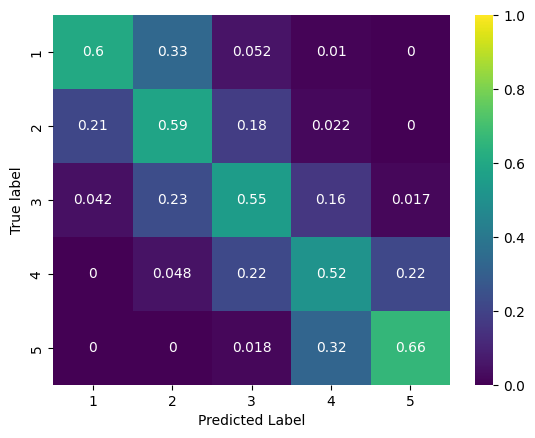

In [117]:
show_best_metrics(result, embedding_name, "validation")

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))



Accuracy on test:                        0.580090
Accuracy on test (up to ±1):             0.971493


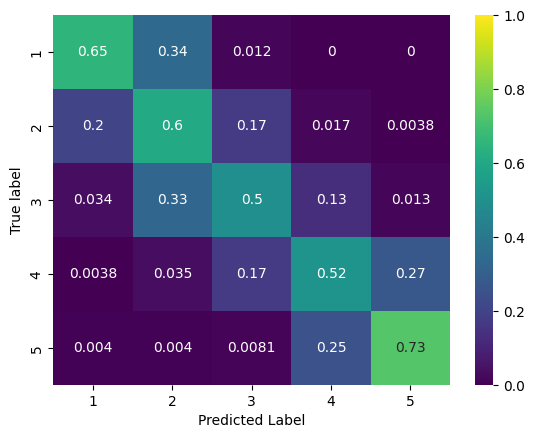

In [118]:
show_best_metrics(result, embedding_name, "test")

In [119]:
save_model(result, embedding_name)

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
